In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Visualization of the optical flow map

In [2]:
def get_frames(filename, frame_number):
    cap = cv2.VideoCapture(filename)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    if frame_number < 0 or frame_number >= total_frames:
        raise Exception('Incorrect input data, frame number must be in range [0, '+str(int(total_frames-1))+']')
    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        _, frame = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number+1)
        _, next_frame = cap.read()
        cap.release()
        return frame, next_frame

resize = lambda frame, scale: cv2.resize(frame, (int(frame.shape[1] * scale), int(frame.shape[0] * scale)), interpolation = cv2.INTER_AREA)

In [274]:
def find_sparse_flow(frame, next_frame, points):
  lk_params = dict( winSize  = (15, 15),
                    maxLevel = 2,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
  [n_points, randomized] = points
  if randomized == 'Shi-Tomasi':
    xy_list = cv2.goodFeaturesToTrack(frame, n_points, 0.01, distance//2)
  elif randomized:
    x = np.random.randint(distance, frame.shape[0]-distance, n_points) 
    y = np.random.randint(distance, frame.shape[1]-distance, n_points)
  else:
    # x, y = np.mgrid[distance//2:frame.shape[0]:distance, distance//2:frame.shape[1]:distance]
    x, y = np.meshgrid(np.linspace(distance, frame.shape[0]-distance, int(np.sqrt(n_points)), dtype=np.int64), 
                        np.linspace(distance, frame.shape[1]-distance, int(np.sqrt(n_points)), dtype=np.int64))
    xy_list = np.asanyarray(list(zip(y.ravel(), x.ravel())), dtype = np.float32)
    xy_list = xy_list.reshape((xy_list.shape[0], 1, xy_list.shape[1]))
  xy_new_list, state, err = cv2.calcOpticalFlowPyrLK(frame, next_frame, xy_list, None, **lk_params)
  return xy_list, xy_new_list, state

def plot_grid(frame, xy_list, xy_new_list, state, plot, color, radius):
  mask = np.zeros_like(frame)
  for xy, xy_new, st in zip(xy_list, xy_new_list, state):
    x, y = xy[0].astype(np.int32)
    x_new, y_new = xy_new[0].astype(np.int32)
    if st:
      mask = cv2.line(mask, (x_new, y_new),(x, y), color, 3)
    frame = cv2.circle(frame,(x, y), radius, (255, 255, 255), -1)
  frame = cv2.add(frame, mask)
  if plot:
    cv2_imshow(resize(frame, 0.5))
  else:
    return frame

In [251]:
path = ''
filename = 'Traffic.flv'
frame_number = 14
distance = 10
colors = [(255, 0, 255), (255, 200, 0), (0, 255, 0), (0, 0, 255)]

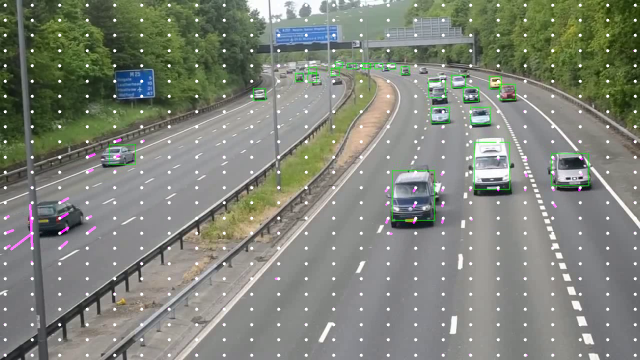

In [272]:
frame, next_frame = get_frames(path+'/'+filename, frame_number)
frame_gray, next_frame_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)]
xy_list, xy_new_list, state = find_sparse_flow(frame_gray, next_frame_gray, [600, False])
plot_grid(next_frame, xy_list, xy_new_list, state, True, colors[0], 3)

### Lucas-Kanade method with Shi-Tomasi

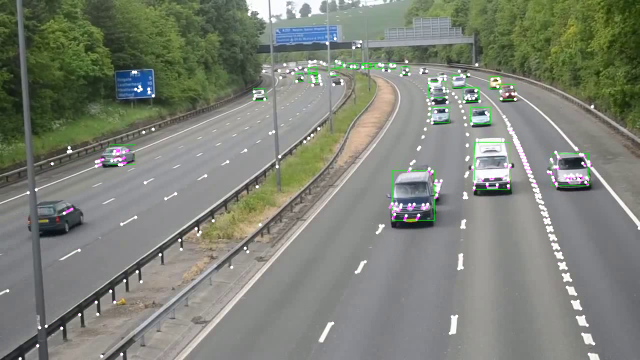

In [278]:
frame, next_frame = get_frames(path+'/'+filename, frame_number)
frame_gray, next_frame_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)]
xy_list, xy_new_list, state = find_sparse_flow(frame_gray, next_frame_gray, [400, 'Shi-Tomasi'])
plot_grid(next_frame, xy_list, xy_new_list, state, True, colors[0], 3)

### Gunnar-Farneback method

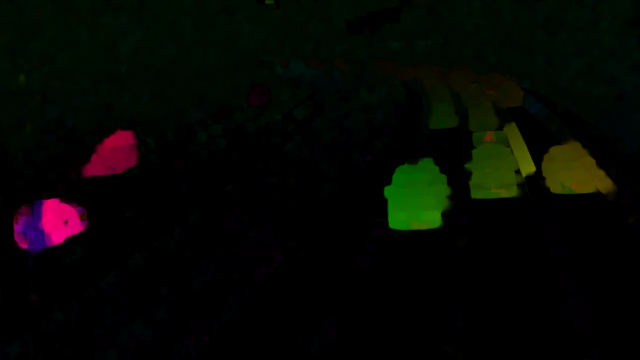

In [276]:
def find_dense_flow(img, frame, next_frame, plot):
  hsv = np.zeros_like(img)
  flow = cv2.calcOpticalFlowFarneback(frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 1] = 255
  hsv[..., 0] = ang*180/np.pi/2
  hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
  bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  if plot:
    cv2_imshow(resize(bgr, 0.5))
  else:
    return bgr

frame, next_frame = get_frames(path+'/'+filename, 15)
frame_gray, next_frame_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)]
find_dense_flow(frame, frame_gray, next_frame_gray, True)

### Operations on channels independently

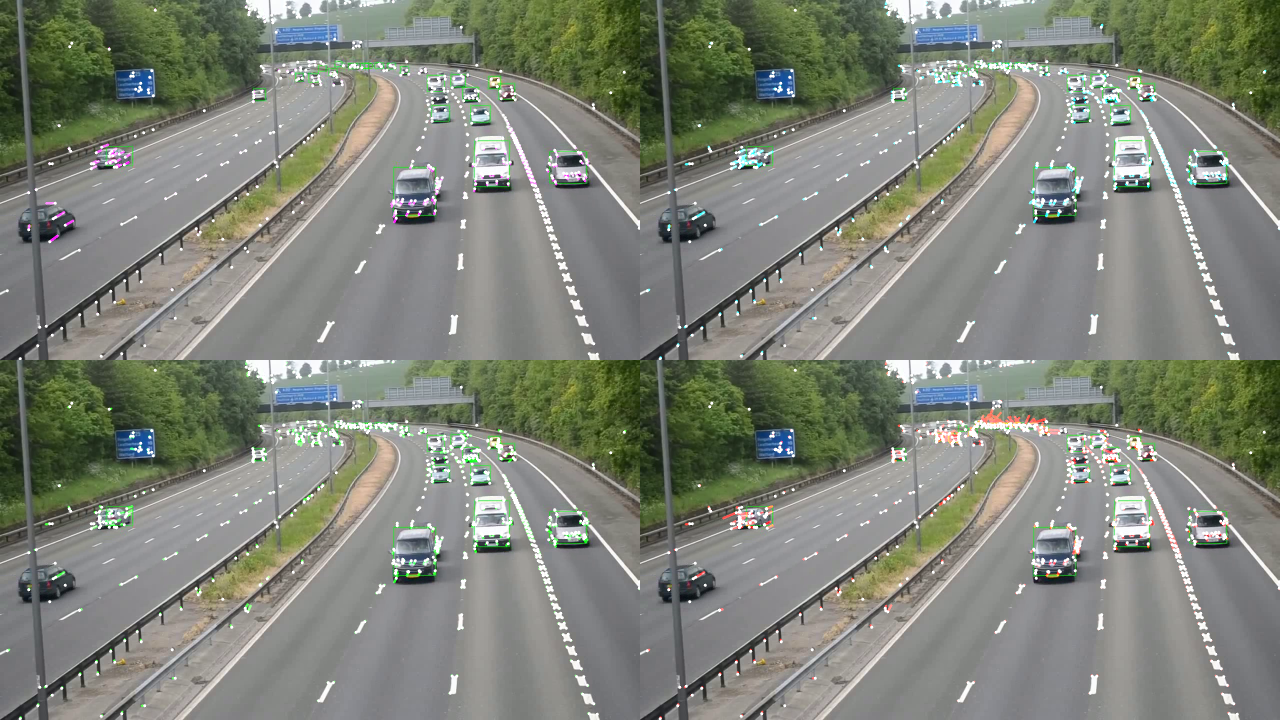

In [281]:
frame_number = 14
frame, next_frame = get_frames(path+'/'+filename, frame_number)
frame_gray, next_frame_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)]
xy_list, xy_new_list, state = find_sparse_flow(frame_gray, next_frame_gray, [500, 'Shi-Tomasi'])
gray = plot_grid(next_frame, xy_list, xy_new_list, state, False, colors[0], 3)

for i in range(3):
  frame_mono, next_frame_mono = [frame[:, :, i], next_frame[:, :, i]]
  xy_list, xy_new_list, state = find_sparse_flow(frame_mono, next_frame_mono, [500, 'Shi-Tomasi'])
  mono_grid = plot_grid(next_frame, xy_list, xy_new_list, state, False, colors[i+1], 3)
  if i == 0:
    gray = np.hstack((gray, mono_grid))
  elif i == 2:
    bgr = np.hstack((bgr, mono_grid))
  else:
    bgr = mono_grid
bgr = np.vstack((gray, bgr))
cv2_imshow(resize(bgr, 0.5))

Różnica ramek: Gray - Blue = 83557823
Różnica wyniku algorytmu G-F: Gray - Blue = 0

Różnica ramek: Gray - Green = 108931775
Różnica wyniku algorytmu G-F: Gray - Green = 0

Różnica ramek: Gray - Red = 66713305
Różnica wyniku algorytmu G-F: Gray - Red = 0



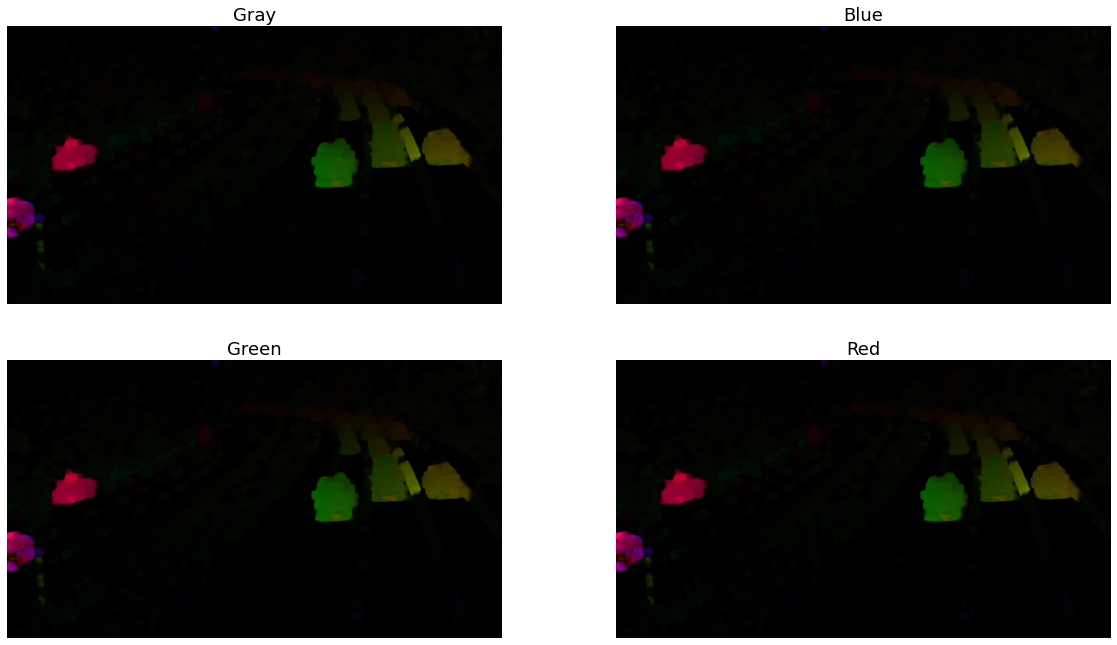

In [270]:
frame_number = 15
frame, next_frame = get_frames(path+'/'+filename, 10)
frame_gray, next_frame_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)]
gray = find_dense_flow(frame, frame_gray, next_frame_gray, False)

plt.figure(figsize=(20, 20*0.5625))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title('Gray', fontsize=18)
plt.axis('off')

for i, color in enumerate(['Blue', 'Green', 'Red']):
  frame, next_frame = get_frames(path+'/'+filename, 10)
  frame_mono, next_frame_mono = [frame[:, :, i], next_frame[:, :, i]]
  mono_grid = find_dense_flow(frame, frame_gray, next_frame_gray, False)
  plt.subplot(2, 2, i+2)
  plt.imshow(cv2.cvtColor(mono_grid, cv2.COLOR_BGR2RGB))
  plt.title(color, fontsize=18)
  plt.axis('off')
  print(f'Różnica ramek: Gray - {color} = {np.sum(frame_gray - frame[:, :, i])}')
  print(f'Różnica wyniku algorytmu G-F: Gray - {color} = {np.sum(gray - mono_grid)}\n')

### Operations in shades of gray for different numbers of points

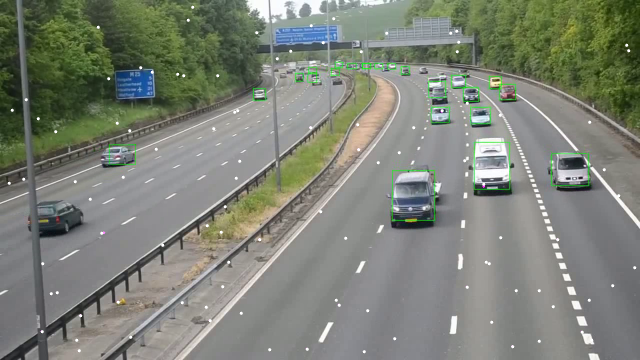

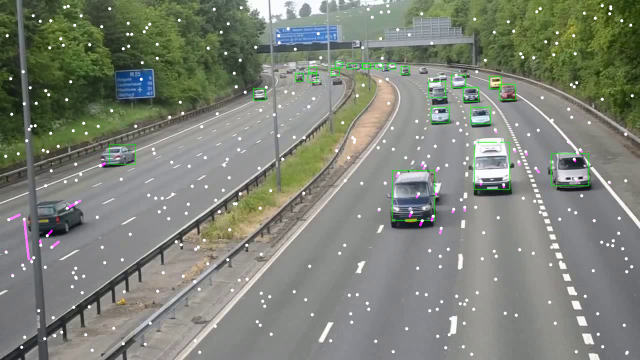

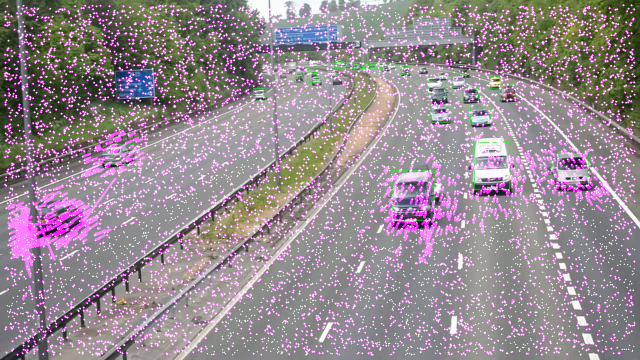

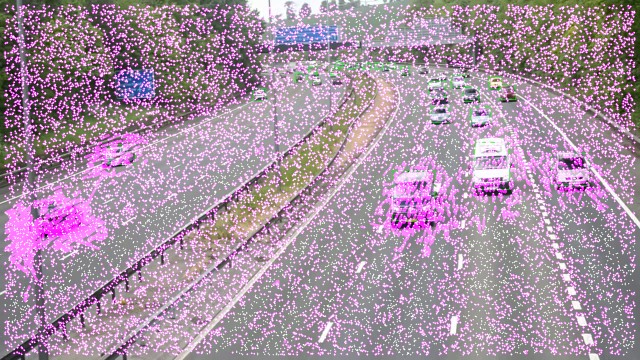

In [261]:
n_points = [100, 400, 10000, 20000]
radius = 3
for n in n_points:
  frame, next_frame = get_frames(path+'/'+filename, frame_number)
  frame_gray, next_frame_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)]
  xy_list, xy_new_list, state = find_sparse_flow(frame_gray, next_frame_gray, [n, True])
  if n >= n_points[-2]:
    radius = 1
  plot_grid(next_frame, xy_list, xy_new_list, state, True, colors[0], radius)

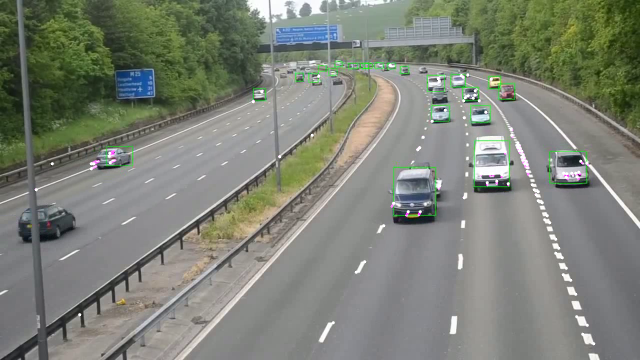

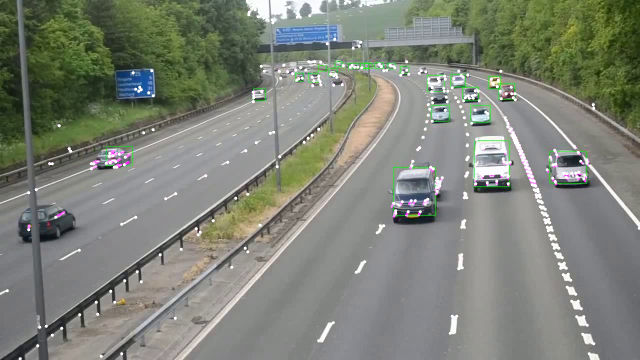

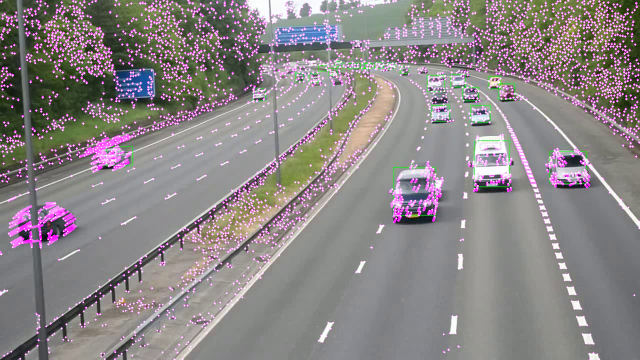

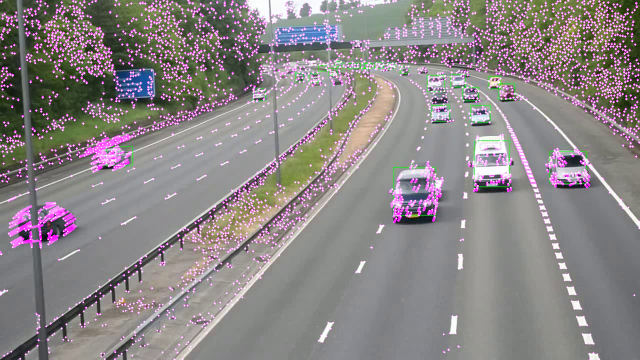

In [282]:
n_points = [100, 400, 10000, 20000]
radius = 3
for n in n_points:
  frame, next_frame = get_frames(path+'/'+filename, frame_number)
  frame_gray, next_frame_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)]
  xy_list, xy_new_list, state = find_sparse_flow(frame_gray, next_frame_gray, [n, 'Shi-Tomasi'])
  if n >= n_points[-2]:
    radius = 1
  plot_grid(next_frame, xy_list, xy_new_list, state, True, colors[0], radius)

### Operating on a grid of points

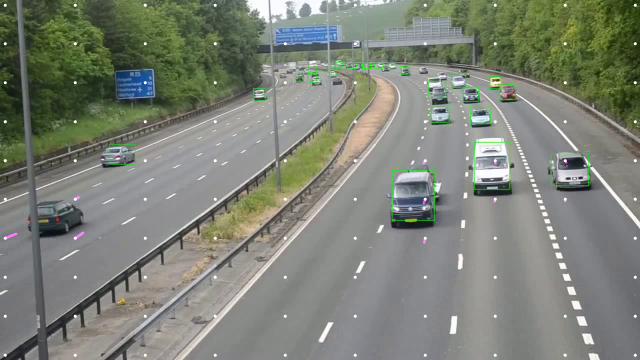

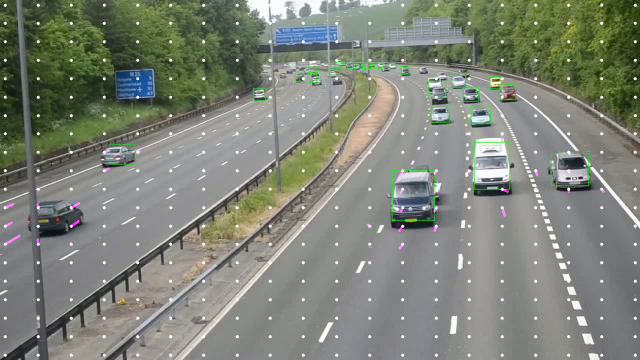

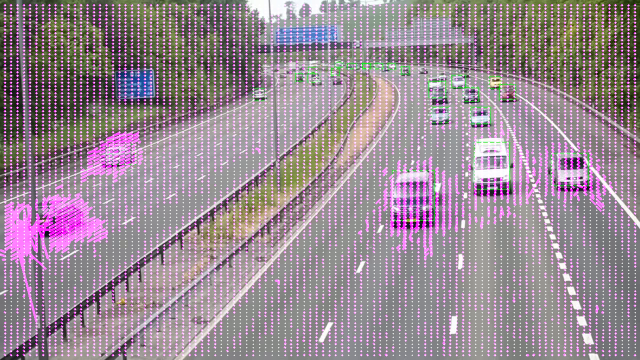

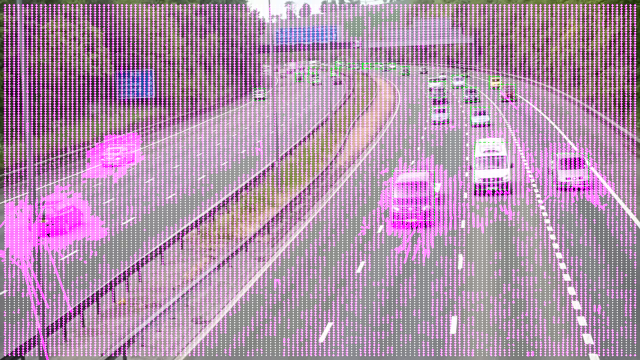

In [263]:
radius = 3
for n in n_points:
  frame, next_frame = get_frames(path+'/'+filename, frame_number)
  frame_gray, next_frame_gray = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)]
  xy_list, xy_new_list, state = find_sparse_flow(frame_gray, next_frame_gray, [n, False])
  if n >= n_points[-2]:
    radius = 1
  plot_grid(next_frame, xy_list, xy_new_list, state, True, colors[0], radius)

### Conclusions:
- The Lukas-Kanade algorithm performed differently for each RGB channel, while the results of the Gunner-Farneback algorithm are the same.
- Using post-observation optical flow of moose points does not work well with a small number of them. 
- The G-F algorithm is better at distinguishing which objects are moving faster/slower than L-K.
- The more the frame is compacted with points, the more visible the moving objects are, although the visibility of the direction of movement fades. 
- The Shi-Tomasi point selection method shows well for both a small number of points and a large number of points, the direction of movement does not vanish as the points increase, while the speed of movement is difficult to estimate.